<a href="https://colab.research.google.com/github/aisha96cs/FYP_DAR/blob/master/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
import time #helper libraries


# Function
convert an array of values into a dataset matrix

In [0]:

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# Read data

In [28]:
df = read_csv('AMZN_data.csv', header=None, index_col=None, delimiter=',')
print(df[:5])
df=df[1:]
print(df[:5])

            0       1       2        3       4        5     6
0        date    open    high      low   close   volume  Name
1  2013-02-08   261.4  265.25  260.555  261.95  3879078  AMZN
2  2013-02-11   263.2  263.25    256.6  257.21  3403403  AMZN
3  2013-02-12  259.19  260.16    257.0   258.7  2938660  AMZN
4  2013-02-13  261.53  269.96    260.3  269.47  5292996  AMZN
            0       1       2        3       4        5     6
1  2013-02-08   261.4  265.25  260.555  261.95  3879078  AMZN
2  2013-02-11   263.2  263.25    256.6  257.21  3403403  AMZN
3  2013-02-12  259.19  260.16    257.0   258.7  2938660  AMZN
4  2013-02-13  261.53  269.96    260.3  269.47  5292996  AMZN
5  2013-02-14  267.37  270.65    265.4  269.24  3462780  AMZN


# Code

In [29]:
# fix random seed for reproducibility
np.random.seed(5)

# take close price column[5]
all_y = df[4].values
#x=df[0].values
dataset=all_y.reshape(-1, 1)
print(all_y)

['261.95' '257.21' '258.7' ... '1390.0' '1442.84' '1416.78']


In [30]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print(dataset)

[[0.01140805]
 [0.00746678]
 [0.0087057 ]
 ...
 [0.94937056]
 [0.9933065 ]
 [0.97163787]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [31]:
# split into train and test sets, 50% test data, 50% training data
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train_size)
print(test_size)

1007
252


In [32]:
# reshape into X=t and Y=t+1, timestep 240
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(testX[:5])
print("-")
print(trainY[:5])

[[0.47518002 0.47655198 0.48162407 0.48916568 0.48904927 0.49429598
  0.49549332]
 [0.47655198 0.48162407 0.48916568 0.48904927 0.49429598 0.49549332
  0.49626661]
 [0.48162407 0.48916568 0.48904927 0.49429598 0.49549332 0.49626661
  0.50572065]
 [0.48916568 0.48904927 0.49429598 0.49549332 0.49626661 0.50572065
  0.50503052]
 [0.48904927 0.49429598 0.49549332 0.49626661 0.50572065 0.50503052
  0.50218682]]
-
[0.01511649 0.01472569 0.01429332 0.00967855 0.00925449]


In [33]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX[:5])
print("-")
print(testX[:5])

[[[0.01140805 0.00746678 0.0087057  0.01766085 0.01746961 0.01401892
   0.01789367]]

 [[0.00746678 0.0087057  0.01766085 0.01746961 0.01401892 0.01789367
   0.01511649]]

 [[0.0087057  0.01766085 0.01746961 0.01401892 0.01789367 0.01511649
   0.01472569]]

 [[0.01766085 0.01746961 0.01401892 0.01789367 0.01511649 0.01472569
   0.01429332]]

 [[0.01746961 0.01401892 0.01789367 0.01511649 0.01472569 0.01429332
   0.00967855]]]
-
[[[0.47518002 0.47655198 0.48162407 0.48916568 0.48904927 0.49429598
   0.49549332]]

 [[0.47655198 0.48162407 0.48916568 0.48904927 0.49429598 0.49549332
   0.49626661]]

 [[0.48162407 0.48916568 0.48904927 0.49429598 0.49549332 0.49626661
   0.50572065]]

 [[0.48916568 0.48904927 0.49429598 0.49549332 0.49626661 0.50572065
   0.50503052]]

 [[0.48904927 0.49429598 0.49549332 0.49626661 0.50572065 0.50503052
   0.50218682]]]


In [34]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
model = Sequential()
model.add(LSTM(25, input_shape=(1, look_back)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=240, verbose=1)

Epoch 1/1000
999/999 [==============================] - 1s 763us/step - loss: 0.0840
Epoch 2/1000
999/999 [==============================] - 0s 39us/step - loss: 0.0677
Epoch 3/1000
999/999 [==============================] - 0s 43us/step - loss: 0.0540
Epoch 4/1000
999/999 [==============================] - 0s 43us/step - loss: 0.0425
Epoch 5/1000
999/999 [==============================] - 0s 42us/step - loss: 0.0326
Epoch 6/1000
999/999 [==============================] - 0s 41us/step - loss: 0.0249
Epoch 7/1000
999/999 [==============================] - 0s 42us/step - loss: 0.0186
Epoch 8/1000
999/999 [==============================] - 0s 39us/step - loss: 0.0142
Epoch 9/1000
999/999 [==============================] - 0s 38us/step - loss: 0.0107
Epoch 10/1000
999/999 [==============================] - 0s 41us/step - loss: 0.0090
Epoch 11/1000
999/999 [==============================] - 0s 39us/step - loss: 0.0072
Epoch 12/1000
999/999 [==============================] - 0s 41us/step - l

In [0]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [0]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [37]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 10.02 RMSE
Test Score: 18.94 RMSE


# Graphs

In [38]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
print(trainPredictPlot[:5])
print("-")
trainPredictPlot[:, :] = np.nan
print(trainPredictPlot[:5])
print("-")
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
print(trainPredictPlot[:5])

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

[[2.45417284e-315]
 [5.07869445e-317]
 [4.98512237e-320]
 [            nan]
 [3.05584648e-061]]
-
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]]
-
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]]


testPrices:
testPredictions:
[[ 847.1901 ]
 [ 847.78314]
 [ 856.16223]
 [ 858.46924]
 [ 856.446  ]
 [ 851.83527]
 [ 851.3646 ]
 [ 848.8408 ]
 [ 853.90906]
 [ 853.6381 ]
 [ 853.36505]
 [ 851.5209 ]
 [ 849.7941 ]
 [ 852.4036 ]
 [ 855.3349 ]
 [ 855.8418 ]
 [ 857.791  ]
 [ 856.5982 ]
 [ 856.14075]
 [ 856.72363]
 [ 855.9505 ]
 [ 858.9272 ]
 [ 850.8999 ]
 [ 850.91327]
 [ 851.1587 ]
 [ 848.9048 ]
 [ 850.38635]
 [ 856.9763 ]
 [ 870.7244 ]
 [ 877.55133]
 [ 886.59735]
 [ 892.9692 ]
 [ 903.63934]
 [ 909.6579 ]
 [ 904.136  ]
 [ 899.73944]
 [ 905.68713]
 [ 904.05786]
 [ 900.7419 ]
 [ 892.7537 ]
 [ 899.60956]
 [ 903.6775 ]
 [ 902.48413]
 [ 905.4405 ]
 [ 902.42444]
 [ 906.17395]
 [ 909.48047]
 [ 910.9831 ]
 [ 918.0698 ]
 [ 924.40857]
 [ 941.8127 ]
 [ 947.86273]
 [ 944.70233]
 [ 941.64355]
 [ 936.4569 ]
 [ 944.5696 ]
 [ 951.7689 ]
 [ 951.19147]
 [ 950.71893]
 [ 958.4617 ]
 [ 958.2255 ]
 [ 964.36053]
 [ 953.1414 ]
 [ 956.25995]
 [ 959.4705 ]
 [ 966.5357 ]
 [ 971.9691 ]
 [ 978.8856 ]
 [ 989.0591 ]
 [ 99

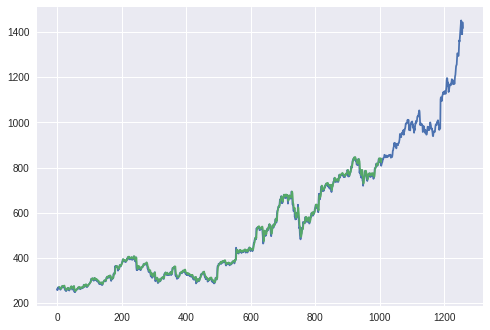

In [39]:
import datetime
#x=[datetime.datetime.strptime(i, '%Y-%m-%d') for i in x]
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
print('testPrices:')
testPrices=scaler.inverse_transform(dataset[test_size+look_back:])

print('testPredictions:')
print(testPredict)

In [0]:
# export prediction and actual prices
prediction=pd.Series( np.around(list(testPredict.reshape(-1))) )
test_price=pd.Series( np.around(list(testPrices.reshape(-1))) )
df = pd.DataFrame(data={"prediction":prediction, "test_price":test_price})
df.to_csv("lstm_result.csv")

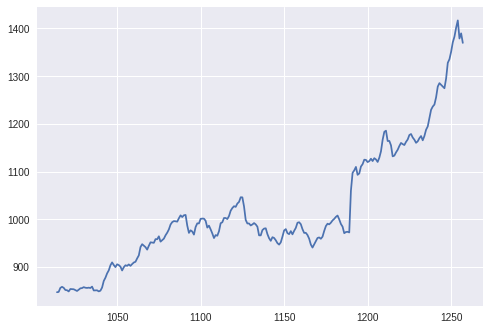

In [41]:
# plot the actual price, prediction in test data=red line, actual price=blue line
plt.plot(testPredictPlot)
plt.show()